In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [2]:
def download_etf_data(etf_list, start_date, end_date):
    etf_list = pd.unique(etf_list)
    data = pd.DataFrame()
    for etf in etf_list:
        try:
            etf_data = yf.download(etf, start=start_date, end=end_date)['Adj Close']
            etf_data.rename(etf, inplace=True)
            data = pd.concat([data, etf_data], axis=1)
        except Exception as e:
            print(f"Failed to download data for {etf}: {e}")
    data = data.loc[:, ~data.columns.duplicated()]
    return data

def calculate_returns(data):
    data = data.loc[:, ~data.columns.duplicated()]
    returns = data.pct_change(fill_method=None)
    returns = returns.dropna(how='all')
    return returns

def calculate_ewma_statistics(returns, span=1260):
    ewma_mean = returns.ewm(span=span).mean().iloc[-1]
    ewma_std = returns.ewm(span=span).std().iloc[-1]
    return ewma_mean, ewma_std

def calculate_ewma_covariance_matrix(returns, span=1260):
    """
    Calculates the EWMA covariance matrix for all ETFs.
    """
    ewm_cov = returns.ewm(span=span).cov()
    # Identify which level of the MultiIndex contains the dates
    level0 = ewm_cov.index.get_level_values(0)
    level1 = ewm_cov.index.get_level_values(1)
    if isinstance(level0[0], pd.Timestamp):
        date_level = 0
    elif isinstance(level1[0], pd.Timestamp):
        date_level = 1
    else:
        raise ValueError("No date level found in ewm_cov index.")
    # Get the last date from the correct index level
    last_date = ewm_cov.index.get_level_values(date_level).max()
    # Extract the covariance matrix corresponding to the last date
    ewma_cov_matrix = ewm_cov.xs(last_date, level=date_level)
    return ewma_cov_matrix



def calculate_sortino_ratio_ewma(returns, annual_rfr=0.04, span=1260):
    daily_rfr = annual_rfr / 252
    ewma_mean = returns.ewm(span=span).mean()
    ewma_downside_std = returns[returns < daily_rfr].ewm(span=span).std()
    expected_returns = ewma_mean.iloc[-1]
    downside_std = ewma_downside_std.iloc[-1]
    sortino_ratios = (expected_returns - daily_rfr) / downside_std
    sortino_ratios = sortino_ratios.replace([np.inf, -np.inf], np.nan).dropna().sort_values(ascending=False)
    return sortino_ratios

def optimize_portfolio_ewma(returns, selected_etfs, annual_rfr, span=1260):
    daily_rfr = annual_rfr / 252
    returns_selected = returns[selected_etfs].dropna(how='any')
    if returns_selected.empty or len(returns_selected) < 2:
        raise ValueError("No overlapping data or insufficient data for selected ETFs.")
    ewma_expected_returns = returns_selected.ewm(span=span).mean().iloc[-1]
    ewm_cov = returns_selected.ewm(span=span).cov().dropna()
    last_date = ewm_cov.index.get_level_values(0).max()
    ewma_cov_matrix = ewm_cov.loc[last_date]
    ewma_cov_matrix = ewma_cov_matrix.loc[selected_etfs, selected_etfs]
    def negative_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, ewma_expected_returns)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(ewma_cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - daily_rfr) / portfolio_std_dev
        return -sharpe_ratio
    n_assets = len(selected_etfs)
    initial_guess = np.array([1 / n_assets] * n_assets)
    bounds = [(0, 1)] * n_assets
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    result = minimize(
        negative_sharpe_ratio,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    if result.success:
        optimized_weights = result.x
        portfolio_return = np.dot(optimized_weights, ewma_expected_returns)
        portfolio_std_dev = np.sqrt(np.dot(optimized_weights.T, np.dot(ewma_cov_matrix, optimized_weights)))
        sharpe_ratio = (portfolio_return - daily_rfr) / portfolio_std_dev
        portfolio = pd.DataFrame({'ETF': selected_etfs, 'Weight': optimized_weights})
        portfolio['Weight'] = portfolio['Weight'] / portfolio['Weight'].sum()
        return portfolio, portfolio_return, portfolio_std_dev, sharpe_ratio
    else:
        raise ValueError("Optimization failed.")

def plot_ios(portfolios, returns, annual_rfr):
    daily_rfr = annual_rfr / 252
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(portfolios)))
    max_sharpe = None
    max_sharpe_return = None
    max_sharpe_std_dev = None
    for idx, portfolio_data in enumerate(portfolios):
        portfolio = portfolio_data['Portfolio']
        selected_etfs = portfolio['ETF'].tolist()
        returns_selected = returns[selected_etfs].dropna(how='any')
        if returns_selected.empty or len(returns_selected) < 2:
            print(f"No overlapping data or insufficient data for portfolio {idx+1}. Skipping.")
            continue
        expected_returns = returns_selected.mean()
        cov_matrix_selected = returns_selected.cov()
        num_portfolios = 500
        results = np.zeros((num_portfolios, 3))
        for i in range(num_portfolios):
            weights = np.random.random(len(selected_etfs))
            weights /= np.sum(weights)
            port_return = np.dot(weights, expected_returns)
            port_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_selected, weights)))
            sharpe_ratio = (port_return - daily_rfr) / port_std_dev
            results[i] = [port_std_dev, port_return, sharpe_ratio]
            if (max_sharpe is None) or (sharpe_ratio > max_sharpe):
                max_sharpe = sharpe_ratio
                max_sharpe_return = port_return
                max_sharpe_std_dev = port_std_dev
        color = colors[idx % len(colors)]
        label = '+'.join(selected_etfs)
        plt.scatter(results[:, 0], results[:, 1], label=label, color=color, alpha=0.5, s=10)
    plt.scatter(0, daily_rfr, color='black', marker='o', label='Risk-Free Asset', s=50)
    if max_sharpe is not None:
        x_vals = np.linspace(0, max_sharpe_std_dev * 1.5, 100)
        cal_line = daily_rfr + max_sharpe * x_vals
        plt.plot(x_vals, cal_line, color='red', linestyle='--', label='Capital Allocation Line (CAL)')
    plt.title('Investment Opportunity Set (IOS) of Suggested Portfolios')
    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Expected Return')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_historical_performance(suggested_portfolios, returns):
    plt.figure(figsize=(12, 8))
    for idx, portfolio_data in enumerate(suggested_portfolios):
        portfolio = portfolio_data['Portfolio']
        selected_etfs = portfolio['ETF'].tolist()
        weights = portfolio['Weight'].values
        returns_selected = returns[selected_etfs].dropna(how='any')
        if returns_selected.empty or len(returns_selected) < 2:
            print(f"No overlapping data or insufficient data for portfolio {idx+1}. Skipping.")
            continue
        portfolio_returns = returns_selected.mul(weights, axis=1).sum(axis=1)
        cumulative_returns = (1 + portfolio_returns).cumprod()
        label = '+'.join(selected_etfs)
        plt.plot(cumulative_returns.index, cumulative_returns.values, label=label)
    plt.title('Historical Performance of Suggested Portfolios')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()




In [3]:
start_date = '2019-01-01'
end_date = '2024-10-14'
annual_rfr = 0.04
span = 1260
etf_list = ['IYR', 'QQQ', 'SMH', 'EWI', 'IWB', 'AGG', 'ICSU.L', 'KXI', 'IUSG', 
            'EWP', 'EFA', 'XSW', 'GREK', 'IJR', 'CSMIB.MI', 'XLF', 'EWY', 'HERG.L',
            'USO', 'XAR', 'EWG', 'BRND.L', 'GLD', 'ONEQ', 'VHYL.L', 'SCHD', 'GXC', 
            'EWQ', 'ITA', 'XLP', 'EWC', 'QTEC', 'IUFS.L', 'TUR', '^N225', 
            'LTAM.MI', 'VUKG.L', 'SPY', 'EWN', 'XHB', 'FXI', 'RYH', 'SCHA', 'KWEB',
            'EZA', '^RUT', 'QDVE.DE', 'EWA', 'XLY', 'XSD', 'CEBS.DE', 'XLE', 'GDXJ', 
            'EGPT', 'FSTA', 'SPY4.DE', 'VWO', 'FUTY', 'VGOV.L', 'SCHB', 'FEUZ.L', 'VGK',
            'NUCG.L', '^STOXX50E', 'EEM', 'FMAT', 'IXG', 'SCHE', 'IHI', 'IEMG', 'HEALL.XC',
            'WLDS.L', 'XLU', 'EWD', 'IWO', 'IUESX', 'VNM', 'XLI', 'IHF', 'INDA', 'SPLG',
            '^IBEX', 'IWN', 'VWRP.L', 'EPHE', 'RCD', 'DFNS.L', 'RXI', 'HEAW.L', 'SCHF', 
            'EWU', 'FSEM.L', 'EMLC', 'IDX', 'SCHC', 'EWH', 'XLV', 'EWW', 'WIGG.L', 'IWP', 
            'RHS', 'EQQQ.DE', 'WCOS.AS', 'IWF', 'IEV', 'SCHX', 'XME', 'GDX', 'UNG', 'EIS', 
            'RSX', 'SGLN.L', 'EWL', 'IWD', 'EWO', 'IWS', 'IVV', 'XLK', 'IXJ', 'SCHG', 'SCHV', 
            'XLB', 'EWZ', 'IWR', 'EWJ', 'PSJ', 'THD', 'EMB', 'IJH', 'ECH', 'EWT', 'GSEM.L', 
            'IUSV', 'STW.PA', 'IWM', 'XRT', 'ARGT', 'VEA', 'FIDU', 'PKW', 'EPOL', 'XLRE',
            'INRG.MI','CUKX.L','IGUS.L','CPJ1.L','EHYG.L','EEDG.L','EMHG.L','ROLG.L','FXC',
            'IGLT.L','UESD.L','SSLN.L','EMGA.L','ECAR.L','TLT5.L','WTRE','STHS.L','GGRG.L',
            'NATP.L','TLTE','XSOE','GOAI.SW','GSLC','TKN.TO','FSMG.L','CLMP.L','CMDY','KWEB',
            'KLWD.L','WBIO.L','TLT5.L','ARKG','ARKK','ARKW','REUSEM.XC','PSI20.LS','EWQ','^STI','EWA',
            'EWZ','^MXY','REUG', '^FCHI','^NQMAMCN','^DJEG20','XIU.TO','^HSI','000001.SS'
            '^NSEI','IDX','PSEI.PS','XU100.IS','ATX','^EWN-IV','^OMX','^OMXC25','^OMXH25','ESNB.DE',
            '0P0000RRIV.SW','^MERV','VNM','GLD3','TRET.L','HINS.L','HPRO.L','ROLG.L','WCOA','COCO.MI',
            'UGAS.MI','KC=F','3HCL.MI','SPDM.L','CYSE.L','WLDS.L','DLTM.L','LILAK','ALAG.L','LGQM.DE','GGAL',
            'YPFD.BA','PAM','SPY']
data = download_etf_data(etf_list, start_date, end_date)



C:\Users\Umowy\AppData\Local\Temp\ipykernel_5672\1467328809.py:2: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  etf_list = pd.unique(etf_list)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 com

In [4]:
excluded_etfs = ['REUS.L','UESD.L','TLT','REUSEM.XC','HEALL.XC','ARGT','EGPT','^MERV']  # Replace with ETFs you want to exclude
data = data.drop(columns=excluded_etfs, errors='ignore')

In [28]:
returns = calculate_returns(data)
ewma_expected_returns, ewma_std_devs = calculate_ewma_statistics(returns, span=1260)
ewma_cov_matrix = calculate_ewma_covariance_matrix(returns, span=1260)
sortino_ratios = calculate_sortino_ratio_ewma(returns, annual_rfr, span=1260)
print("Sortino Ratios (EWMA):")
print(sortino_ratios.head(10))

# Selection of ETFs

# 9 best Sortino ratios tagged as 'best'
best_etfs = sortino_ratios.head(16).index.tolist()
etf_tags = {etf: 'best' for etf in best_etfs}

# 4 highest expected returns (excluding already selected), tagged as 'earn'
remaining_etfs = ewma_expected_returns.drop(index=best_etfs)
top_er_etfs = remaining_etfs.sort_values(ascending=False).head(4).index.tolist()
for etf in top_er_etfs:
    etf_tags[etf] = 'earn'

# Combine selected ETFs
selected_etfs = best_etfs + top_er_etfs
used_etfs = set(selected_etfs)

# For each selected ETF, find ETFs according to specified criteria
for etf in best_etfs + top_er_etfs:
    # Find lowest covariance pair (tagged 'hedge')
    remaining = set(returns.columns) - used_etfs
    if not remaining:
        break
    cov_series = ewma_cov_matrix.loc[etf, list(remaining)].dropna()
    if cov_series.empty:
        continue
    hedge_etf = cov_series.idxmin()
    selected_etfs.append(hedge_etf)
    etf_tags[hedge_etf] = 'hedge'
    used_etfs.add(hedge_etf)
    
    # Find lowest covariance ETF with e(r) > risk-free rate (tagged 'mid')
    er_filtered = ewma_expected_returns[list(remaining)]
    er_filtered = er_filtered[er_filtered > annual_rfr / 252]
    if not er_filtered.empty:
        cov_series_er = ewma_cov_matrix.loc[etf, er_filtered.index].dropna()
        if not cov_series_er.empty:
            mid_etf = cov_series_er.idxmin()
            selected_etfs.append(mid_etf)
            etf_tags[mid_etf] = 'mid'
            used_etfs.add(mid_etf)
    
    # Find lowest covariance ETF from top 20% Sortino ratio (tagged 'high')
    sortino_top_20 = sortino_ratios.head(int(len(sortino_ratios) * 0.2))
    remaining_high = set(sortino_top_20.index) - used_etfs
    if remaining_high:
        cov_series_high = ewma_cov_matrix.loc[etf, list(remaining_high)].dropna()
        if not cov_series_high.empty:
            high_etf = cov_series_high.idxmin()
            selected_etfs.append(high_etf)
            etf_tags[high_etf] = 'high'
            used_etfs.add(high_etf)

print("\nSelected ETFs and their tags:")
for etf in selected_etfs:
    print(f"{etf}: {etf_tags.get(etf, 'unlabeled')}")

selected_etfs = list(used_etfs)
print("\nFinal list of candidate ETFs:")
print(selected_etfs)

# Check overlapping data
returns_selected = returns[selected_etfs].dropna()
if len(returns_selected) < 200:
    print("\nInsufficient overlapping data for selected ETFs.")
    # Optionally, implement logic to exclude problematic ETFs and select replacements
else:
    print("\nSufficient overlapping data for selected ETFs.")


Sortino Ratios (EWMA):
XU100.IS    0.862672
EHYG.L      0.537999
DFNS.L      0.461118
NATP.L      0.416556
GOAI.SW     0.370798
YPFD.BA     0.367465
CEBS.DE     0.148971
EEDG.L      0.139111
VWRP.L      0.138591
3HCL.MI     0.137909
Name: 2024-03-29 00:00:00, dtype: float64

Selected ETFs and their tags:
XU100.IS: best
EHYG.L: best
DFNS.L: best
NATP.L: best
GOAI.SW: best
YPFD.BA: best
CEBS.DE: best
EEDG.L: best
VWRP.L: best
3HCL.MI: best
GGAL: best
NUCG.L: best
VUKG.L: best
COCO.MI: best
SMH: best
SCHD: best
UGAS.MI: earn
QDVE.DE: earn
EQQQ.DE: earn
TKN.TO: earn
SGLN.L: mid
SGLN.L: mid
GLD: high
ICSU.L: mid
ICSU.L: mid
KC=F: high
FSMG.L: hedge
ROLG.L: mid
SCHV: high
TLT5.L: hedge
THD: mid
IUSV: high
RHS: mid
RHS: mid
PAM: high
VGOV.L: hedge
STHS.L: mid
GSLC: high
WCOS.AS: mid
WCOS.AS: mid
SPLG: high
ESNB.DE: hedge
GDX: mid
XLI: high
IGLT.L: hedge
CMDY: mid
SPY: high
HINS.L: mid
HINS.L: mid
IVV: high
AGG: hedge
PSEI.PS: mid
ECAR.L: high
RSX: hedge
XLP: mid
IWB: high
FSEM.L: hedge
WIGG.L

In [29]:
# Calculate the number of non-NaN entries for each selected ETF
data_coverage = data[selected_etfs].notna().sum().sort_values()

print("Data Coverage for Each Selected ETF:")
print(data_coverage)


Data Coverage for Each Selected ETF:
GOAI.SW     230
CEBS.DE     258
HINS.L      270
NATP.L      325
TLT5.L      360
           ... 
UGAS.MI    1473
3HCL.MI    1473
QDVE.DE    1473
COCO.MI    1473
WCOS.AS    1483
Length: 71, dtype: int64


In [30]:
print(data.isna().sum())


IYR        50
QQQ        50
SMH        50
EWI        50
IWB        50
           ..
ALAG.L     45
LGQM.DE    32
GGAL       50
YPFD.BA    97
PAM        50
Length: 207, dtype: int64


In [31]:
try:
    portfolio, port_return, port_std_dev, sharpe_ratio = optimize_portfolio_ewma(
        returns, selected_etfs, annual_rfr, span=1260)
    portfolio['Weight'] = portfolio['Weight'].apply(lambda x: round(x, 3))
    print("\nOptimized Portfolio:")
    print(portfolio)
    print(f"Expected Return: {port_return:.5f}, Std Dev: {port_std_dev:.5f}, Sharpe Ratio: {sharpe_ratio:.5f}")
    suggested_portfolios = [{
        'Portfolio': portfolio,
        'Returns': [port_return],
        'StdDevs': [port_std_dev],
        'SharpeRatio': sharpe_ratio
    }]
except ValueError as e:
    print(f"Optimization failed: {e}")



Optimized Portfolio:
        ETF  Weight
0   WCOS.AS   0.000
1    IGLT.L   0.000
2      SPLG   0.000
3      GGAL   0.040
4    FSMG.L   0.000
..      ...     ...
66  QDVE.DE   0.024
67      XLI   0.000
68   VUKG.L   0.000
69   HEAW.L   0.000
70   EEDG.L   0.000

[71 rows x 2 columns]
Expected Return: 0.00177, Std Dev: 0.00315, Sharpe Ratio: 0.51306


In [44]:
try:
    portfolio, port_return, port_std_dev, sharpe_ratio = optimize_portfolio_ewma(
        returns, selected_etfs, annual_rfr, span=1260)
    portfolio['Weight'] = portfolio['Weight'].apply(lambda x: round(x, 3))
    
    # Filter out ETFs with weight approximately 0
    filtered_portfolio = portfolio[portfolio['Weight'] > 0]
    
    print("\\nOptimized Portfolio:")
    print(filtered_portfolio)
    print(f"Expected Return: {port_return:.5f}, Std Dev: {port_std_dev:.5f}, Sharpe Ratio: {sharpe_ratio:.5f}")
    suggested_portfolios = [{
        'Portfolio': filtered_portfolio,
        'Returns': [port_return],
        'StdDevs': [port_std_dev],
        'SharpeRatio': sharpe_ratio
    }]
except ValueError as e:
    print(f"Optimization failed: {e}")

\nOptimized Portfolio:
        ETF  Weight
3      GGAL   0.040
13     SCHV   0.026
14   TKN.TO   0.014
31  COCO.MI   0.032
34   SGLN.L   0.107
39     SCHD   0.016
46   ICSU.L   0.087
51      XLU   0.047
52  PSEI.PS   0.110
57   NATP.L   0.010
58   STHS.L   0.175
61     SCHG   0.086
62   FSEM.L   0.227
66  QDVE.DE   0.024
Expected Return: 0.00177, Std Dev: 0.00315, Sharpe Ratio: 0.51306


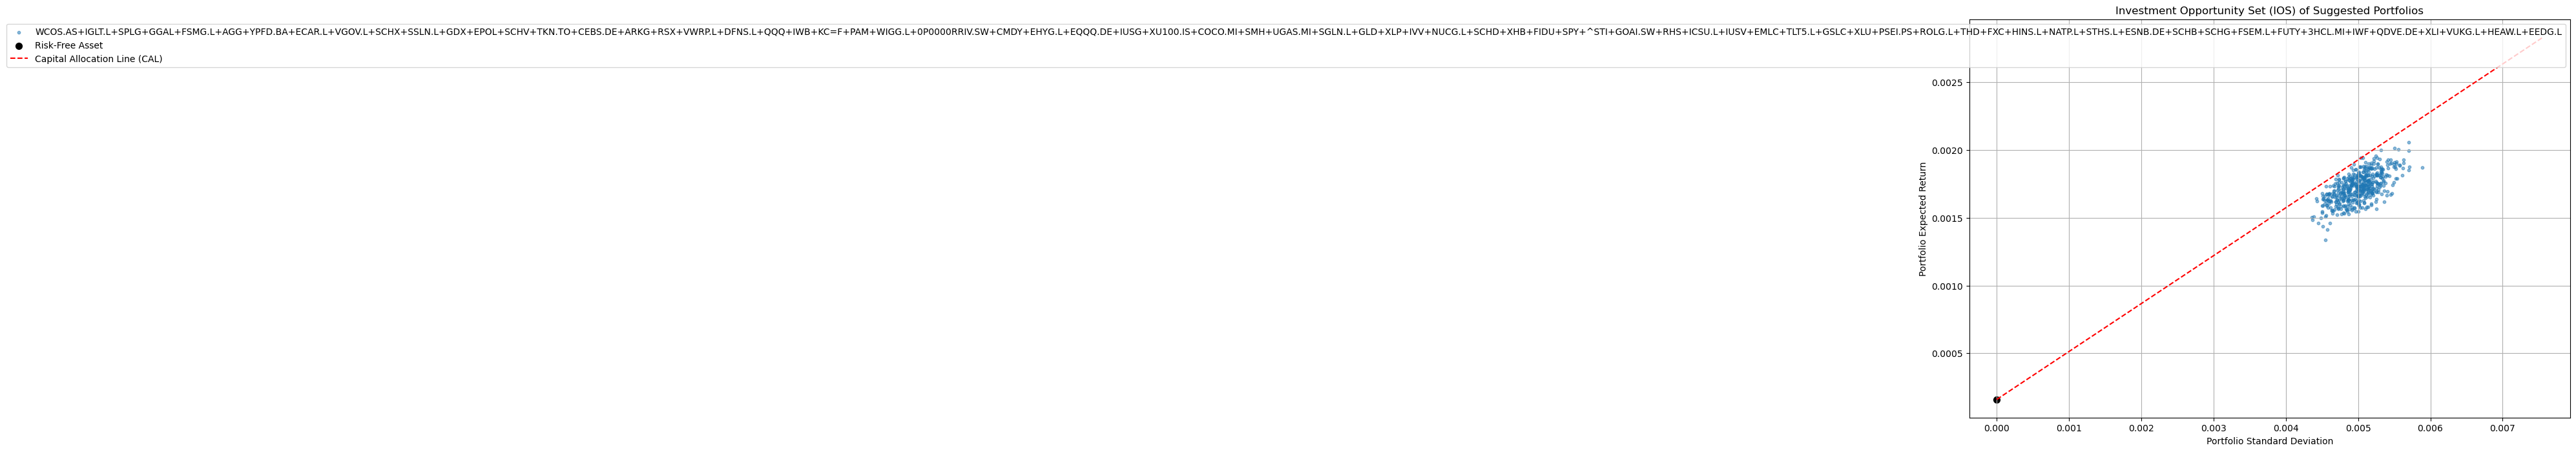

In [33]:
plot_ios(suggested_portfolios, returns, annual_rfr)


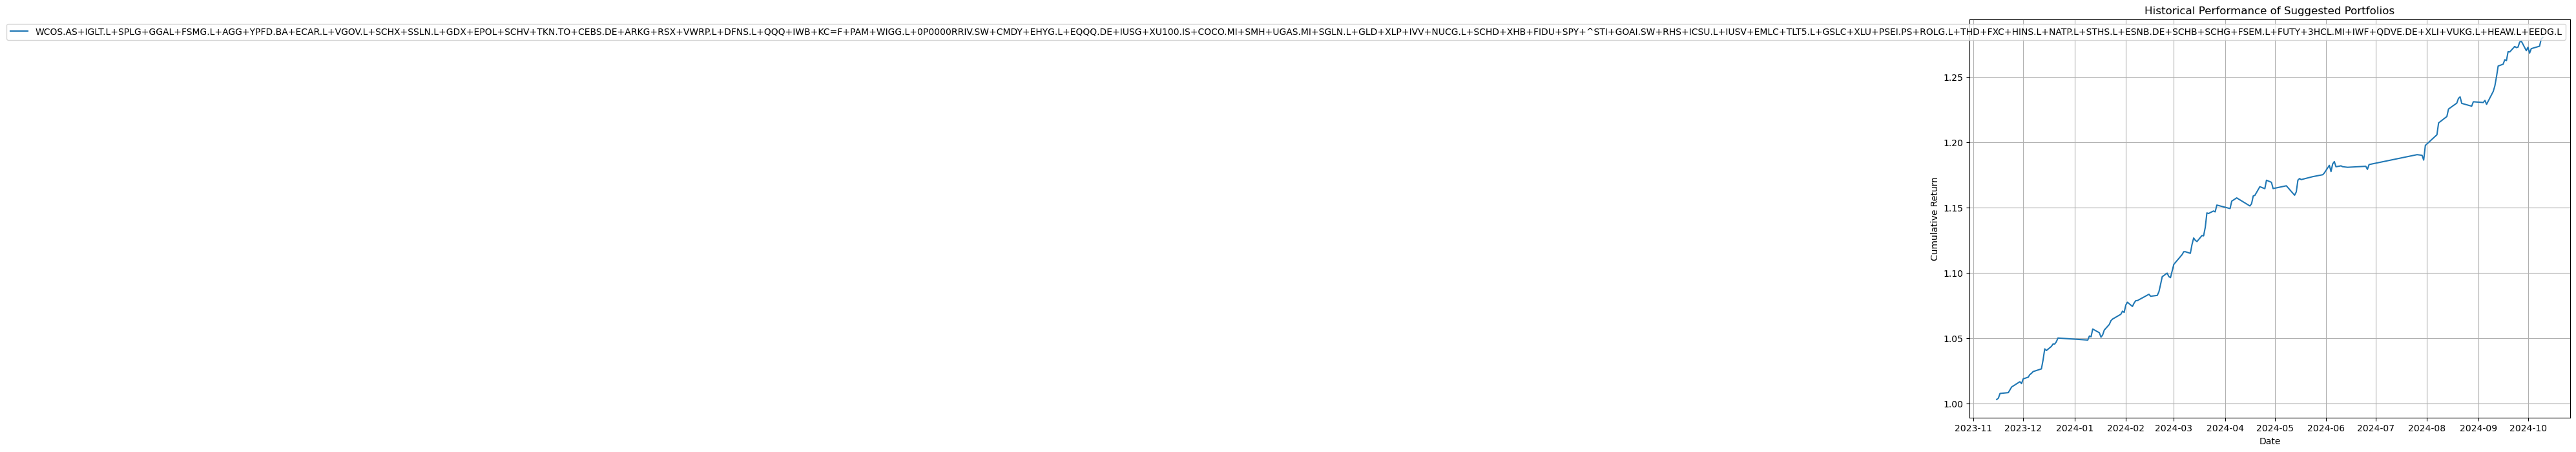

In [34]:
plot_historical_performance(suggested_portfolios, returns)


In [12]:
# Ensure that ^MERV exists in the covariance matrix
if "^MERV" in ewma_cov_matrix.index:
    # Extract the row corresponding to ^MERV
    merv_covariances = ewma_cov_matrix.loc["^MERV"]

    # Sort the covariances in descending order
    sorted_covariances = merv_covariances.sort_values(ascending=False)

    # Display the assets with the highest covariance with ^MERV
    print("Assets with the highest covariance with ^MERV:")
    print(sorted_covariances)
else:
    print("^MERV is not in the covariance matrix.")


^MERV is not in the covariance matrix.
